In [12]:
import matplotlib.cbook as cbook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier

from ensemble import MakeEnsemble
from util import load_data, fdr

In [2]:
x_train, _, x_oot, y_train, _, y_oot = load_data('var_30.csv', test_size=0)
x_train = x_train.to_numpy()

In [3]:
def clf_score(clf, x_train, y_train, label, train_scores, test_scores, oot_scores, cv=10, n_jobs=8):
    score = cross_validate(clf, x_train, y_train, scoring=fdr, cv=cv, n_jobs=n_jobs,
                           return_train_score=True, return_estimator=True)
    train_scores.append(score['train_score'])
    test_scores.append(score['test_score'])
    labels.append(label)
    oot = []
    for clf in score['estimator']:
        oot.append(fdr(clf, x_oot, y_oot))
    oot_scores.append(np.asarray(oot))
    print(np.mean(score['test_score']))

In [4]:
labels = []
train_scores = []
test_scores = []
oot_scores=[]

In [5]:
# Logistic regression
lr = LogisticRegression(max_iter=1000, 
                        C=1, 
                        class_weight='balanced')
clf_score(lr, x_train, y_train, 'LR', train_scores, test_scores, oot_scores, n_jobs=1)

0.5297238060810051


In [6]:
# Decision tree
dt = DecisionTreeClassifier(ccp_alpha=1e-06, 
                            max_depth=20,
                            min_samples_leaf=64, 
                            class_weight=None,
                            criterion='gini')
clf_score(dt, x_train, y_train, 'DT', train_scores, test_scores, oot_scores, n_jobs=1)

0.5440196968914514


In [7]:
# Random forest
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=20,
                            max_features=10,
                            ccp_alpha=1e-6,
                            min_samples_leaf=2,
                            n_jobs=8)
clf_score(rf, x_train, y_train, 'RF', train_scores, test_scores, oot_scores, n_jobs=1)

0.5507320262827737


In [13]:
# Boosted tree
bt = GradientBoostingClassifier(n_estimators=200,
                                max_depth=5,
                                learning_rate=0.05,
                                subsample=0.5,
                                verbose=1)
clf_score(bt, x_train, y_train, 'BT', train_scores, test_scores, oot_scores, n_jobs=8)

0.547593859454599


In [15]:
# Adaboost
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                         learning_rate=0.1,
                         n_estimators=50,
                         algorithm='SAMME.R')
clf_score(ada, x_train, y_train, 'ADA', train_scores, test_scores, oot_scores, n_jobs=8)

0.5490758348547491


In [16]:
# Random forest with random under sampling to 5%
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=20,
                            max_features=10,
                            ccp_alpha=1e-6,
                            min_samples_leaf=2,
                            n_jobs=8)
ee = EasyEnsembleClassifier(n_estimators=50,
                            base_estimator=rf,
                            sampling_strategy=0.5,
                            n_jobs=1,
                            verbose=0)
clf_score(ee, x_train, y_train, 'RF_US', train_scores, test_scores, oot_scores, n_jobs=1)

0.549250126826838


In [17]:
# Decision tree with Random undersample to 10% and then SMOTE
score = {'train_score': [], 'test_score': [], 'oot_score': []}
for _ in range(10):
    x, x_test, y, y_test = train_test_split(x_train, y_train, test_size=0.1)
    dt = DecisionTreeClassifier(ccp_alpha=1e-06, max_depth=20, min_samples_leaf=64, class_weight=None, criterion='gini')
    me = MakeEnsemble(dt, [RandomUnderSampler(sampling_strategy=0.1), SMOTE(sampling_strategy=0.5)],
                      n_estimators=50, n_jobs=8, verbose=0)
    me.fit(x, y)
    score['train_score'].append(fdr(me, x, y))
    score['test_score'].append(fdr(me, x_test, y_test))
    score['oot_score'].append(fdr(me, x_oot, y_oot))

train_scores.append(np.asarray(score['train_score']))
test_scores.append(np.asarray(score['test_score']))
oot_scores.append(np.asarray(score['oot_score']))
labels.append('DT_SMOTE')

In [29]:
pd.DataFrame(test_scores, index=labels).mean(numeric_only=True, axis=1)

LR          0.529724
DT          0.544020
RF          0.550732
BT          0.547594
ADA         0.549076
RF_US       0.549250
DT_SMOTE    0.544952
dtype: float64

In [31]:
pd.DataFrame(oot_scores, index=labels).mean(numeric_only=True, axis=1)

LR          0.518590
DT          0.535262
RF          0.540089
BT          0.538103
ADA         0.539130
RF_US       0.538412
DT_SMOTE    0.533516
dtype: float64

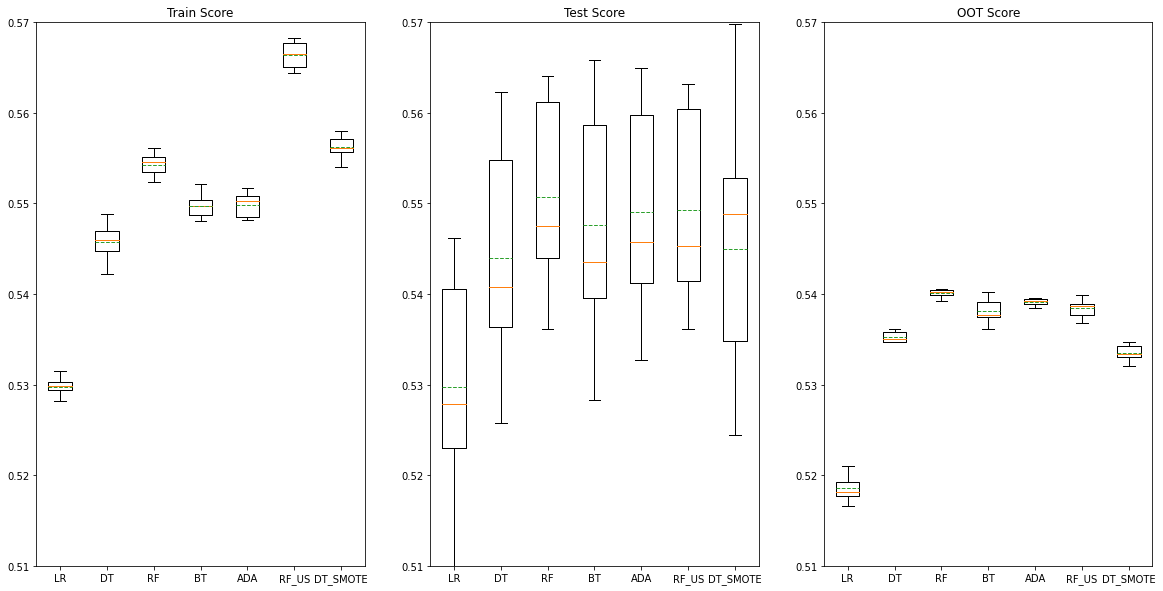

In [33]:
train_stats = cbook.boxplot_stats(train_scores, labels=labels)
test_stats = cbook.boxplot_stats(test_scores, labels=labels)
oot_stats = cbook.boxplot_stats(oot_scores, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
ax[0].bxp(train_stats, showfliers=False, meanline=True, showmeans=True)
ax[0].set_title('Train Score')
ax[1].bxp(test_stats, showfliers=False, meanline=True, showmeans=True)
ax[1].set_title('Test Score')
ax[2].bxp(oot_stats, showfliers=False, meanline=True, showmeans=True)
ax[2].set_title('OOT Score')
for a in ax:
    a.set_ylim(0.51, 0.57)
plt.show()

In [35]:
import pickle
load = {'labels': labels,
        'train_scores': train_scores,
        'test_scores': test_scores,
        'oot_scores': oot_scores}
with open('model_results.dump', 'wb') as f:
    pickle.dump(load, f)